In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.autograd import Variable

from torch.utils.data import TensorDataset, DataLoader

from tqdm.auto import trange

In [ ]:
!pip install navec
from navec import Navec
#path = '../../static/embeddings/navec_hudlit_v1_12B_500K_300d_100q.tar'
path = '/content/navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content

/content


In [ ]:
#train_data = pd.read_csv('../../static/datasets/original/train_data.csv', sep='\t')
train_data = pd.read_csv('train_data.csv', sep='\t')

In [ ]:
def sen_split(sent, elem_split):
      for i in range(len(sent)):
          a = ((sent[i]).split(elem_split))
          if '' in a:
              a.remove('')
          if a:
              sent[i] = a[0].lower()
      return sent

  
def fill_emb(emb, sentences, is_numpy : bool = True):
    for i in range(len(sentences)):
        sentence = sentences[i].split()
        sentence = sen_split(sentence, ",")
        sentence = sen_split(sentence, ":")
        sentence = sen_split(sentence, ";")
        sentence = sen_split(sentence, ".")
        sentence = sen_split(sentence, "-")
        sentence = sen_split(sentence, "?")
        sentence = sen_split(sentence, "!")
        sentence = sen_split(sentence, ")")
        sentence = sen_split(sentence, "(")
        sentence = sen_split(sentence, '"')
        sentence = sen_split(sentence, "'")
        sentence = sen_split(sentence, "«")
        sentence = sen_split(sentence, "»")
        for j in range(len(sentence)):
            if sentence[j] in navec:
                if is_numpy:
                  emb[i][j] = navec[sentence[j]]
                else:
                  emb[i].append(navec[sentence[j]])
    return emb


def to_emb_numpy(train_data, navec) -> np.array:
    sentences = train_data.sentence
    emb = np.zeros((len(sentences), 100, 300))
    return fill_emb(emb, sentences)

  
def to_emb_list(train_data, navec) -> list:
    sentences = train_data.sentence
    emb = [[] for sentence in sentences]
    return fill_emb(emb, sentences, False)

In [ ]:
X = to_emb_list(train_data, navec)
#X = to_emb_numpy(train_data, navec)

In [ ]:
y = pd.DataFrame(train_data['label'])
y.replace(1, 2, inplace=True)
y.replace(0, 1, inplace=True)
y.replace(-1, 0, inplace=True)
y = np.array(y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [ ]:
train_dataloader = iter([(torch.FloatTensor(sentence), torch.LongTensor(label)) for sentence, label in zip(X_train, y_train)])
val_dataloader = iter([(torch.FloatTensor(sentence), torch.LongTensor(label)) for sentence, label in zip(X_val, y_val)])

In [ ]:
#train_dataloader = DataLoader(TensorDataset(torch.permute(torch.from_numpy(X_train), (0, 1, 2)), torch.from_numpy(np.reshape(y_train, len(y_train)))), batch_size=1, shuffle=True)
#val_dataloader = DataLoader(TensorDataset(torch.permute(torch.from_numpy(X_val), (0, 1, 2)), torch.from_numpy(np.reshape(y_val, len(y_val)))), batch_size=1, shuffle=True)

In [ ]:
import gc   

def free_cache(X_batch=None, y_batch=None):
    if X_batch is not None:
        del X_batch
    if y_batch is not None:
        del y_batch
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
from sklearn import metrics as multi_metrics

def calc_f1(probs, y_true) -> float:
    _, pred = torch.max(probs, axis=-1)
    #pred = pred.to('cpu')
    #y_true = y_true.to('cpu')
    return multi_metrics.f1_score(y_true=y_true, y_pred=pred, average='macro')
    

def get_f1(model, X_batch, y_batch) -> float:
    model.eval()
    with torch.no_grad():
        X_batch = X_batch.to(device)
        probs = model(X_batch.float())
    return calc_f1(probs, y_batch)

  
def get_f1_from_list(model, X, y):
    model.eval()
    with torch.no_grad():
        probs = []
        for x in X:
            x = torch.FloatTensor(x).to(device)
            prob = model(x)
            probs.append(prob.numpy())
    probs = torch.FloatTensor(probs)
    return calc_f1(probs, y)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def fit(epochs, batch_size, model_, loss_func, opt, train_dl, valid_dl, lr_sched=None):
    model_ = model_.to(device)
    train_losses = []
    val_losses = []
    val_scores = []
    pbar = trange(epochs * batch_size, desc="Epoch:")
    for epoch in pbar:
        model_.train()
        loss_sum = 0

        xb, yb = next(train_dl)
        xb, yb = xb.to(device), yb.to(device)
        yb = yb.view(-1)
        probs = model_(xb)
            
        loss = loss_func(probs, yb)
        loss_sum += loss.item()
        loss.backward()

        opt.step()
        opt.zero_grad()
        free_cache(xb, yb)

        train_losses.append(loss_sum)


        model_.eval()
        loss_sum = 0
        sum_f1 = 0

        with torch.no_grad():
            xb, yb = next(valid_dl)
            xb, yb = xb.to(device), yb.to(device)
            yb = yb.view(-1)
            probs = model_(xb)

            loss = loss_func(probs, yb)
            loss_sum += loss.item()
                
            sum_f1 += calc_f1(probs, yb)
            free_cache(xb, yb)

        
        val_loss = loss_sum
        val_f1 = sum_f1
        val_losses.append(val_loss)
        val_scores.append(val_f1)

        #if epoch > 0 and epoch % batch_size == 0:
          
        pbar.set_description('Epoch: {} Loss: {:.4f} AverageF1: {:.4f}'.format(epoch, val_loss, val_f1))

        #torch.save(model.state_dict(), PATH)   #сохранение весов модели на будущее

        if lr_sched is not None:
            lr_sched.step()

    return train_losses, val_losses, val_scores


def build_graphs(train_losses: list[float], val_losses: list[float], val_scores : list[float]) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))
    ax1.plot(range(len(train_losses)), train_losses, label='train loss')
    ax1.plot(range(len(val_losses)), val_losses, label='val loss')
    ax1.legend()
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss graph")

    ax2.plot(range(len(val_scores)), val_scores)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("AverageF1")
    ax2.set_title("Score graph")

    fig.tight_layout()
    plt.show();

  
def fit_and_build_graphs(*args):
    build_graphs(*fit(*args))

In [ ]:

class MyRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, bidirectional: bool = False):
        super(MyRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.D = 1
        if bidirectional:
          self.D += 1
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 3)
        )
    
    def forward(self, x):
        #h_0 = Variable(torch.randn(self.num_layers * self.D, x.size(0), self.hidden_size))
        #c_0 = Variable(torch.randn(self.num_layers * self.D, x.size(0), self.hidden_size))
        #out, (h_n, c_n) = self.rnn(x, h_0)
        output, (h_n, c_n) = self.rnn(x)
        #print(h_n)
        out = h_n[-1][None, :]
        out = self.classifier(out)
        return F.softmax(out, dim=1)

Epoch::   0%|          | 0/400 [00:00<?, ?it/s]

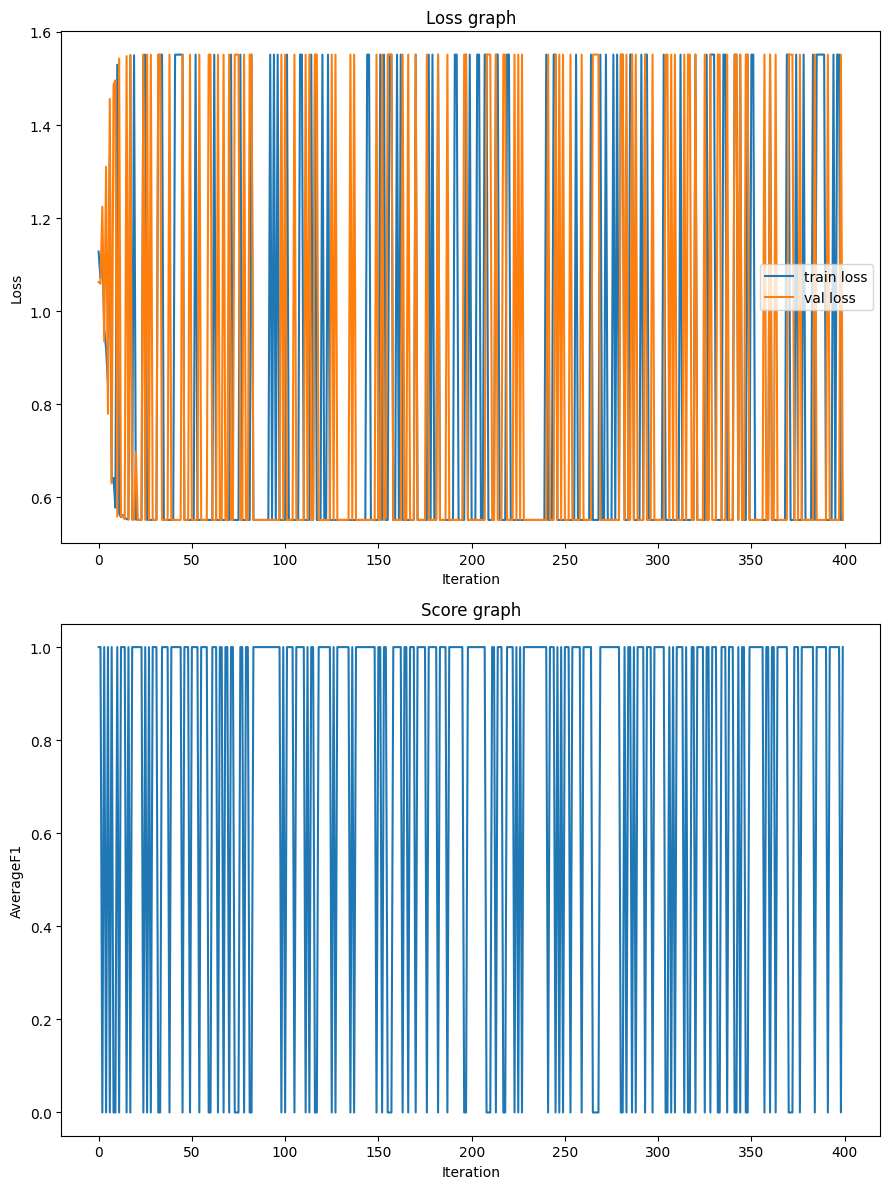

In [ ]:
INPUT_SIZE = 300
BATCH_FIRST = True

rnn = MyRNN(input_size=INPUT_SIZE, hidden_size=50, num_layers=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

fit_and_build_graphs(4, 100, rnn, criterion, optimizer, train_dataloader, val_dataloader)

In [ ]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        # Embedding size, Hyperparameter, Output
        self.fc1 = nn.Linear(300, 4096)
        self.fc2 = nn.Linear(4096, 3)

    def forward(self, x):
        x = torch.mean(x, dim=2)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

Epoch::   0%|          | 0/64 [00:00<?, ?it/s]

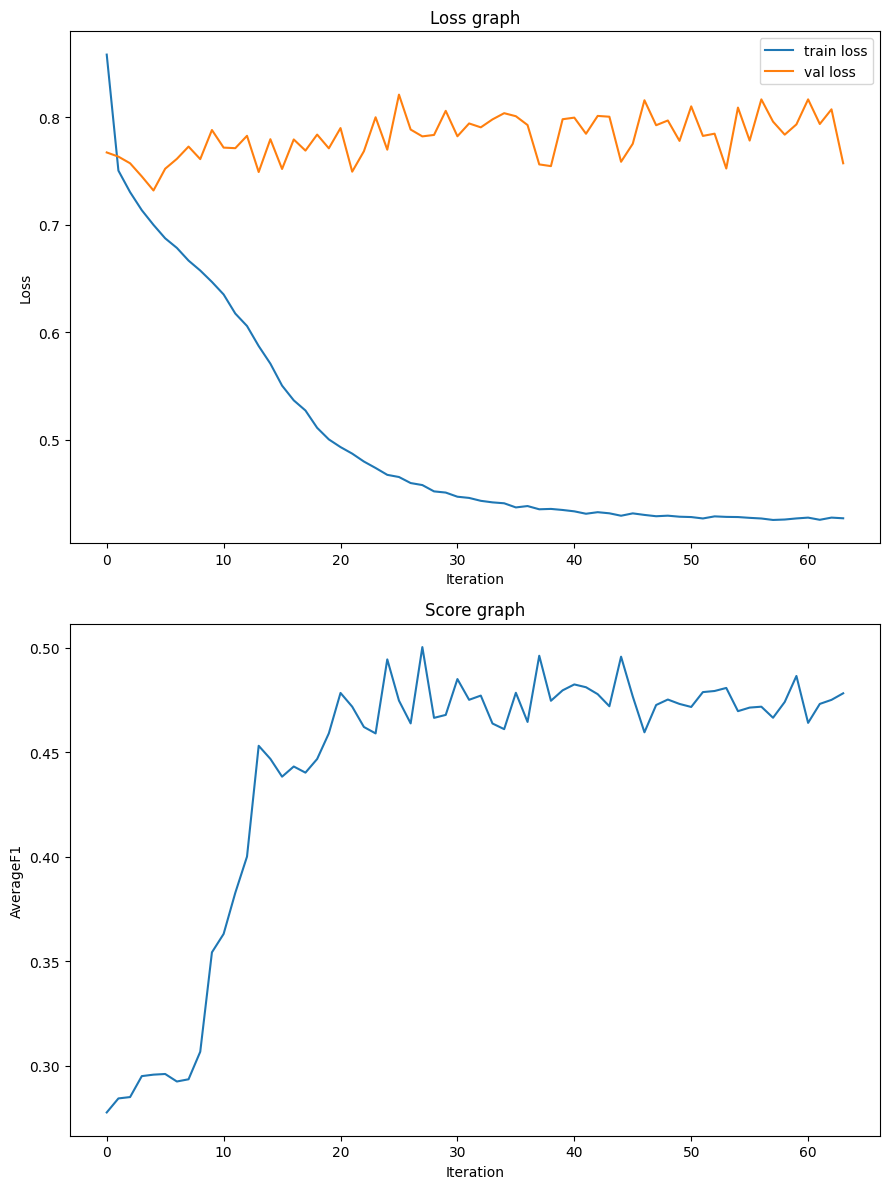

In [ ]:
model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

fit_and_build_graphs(64, model, criterion, optimizer, train_dataloader, val_dataloader, scheduler)

In [ ]:
val_data = pd.read_csv('validation_data_labeled.csv', sep='\t')
X = to_emb_list(val_data, navec)
y = pd.DataFrame(val_data['label'])
y.replace(1, 2, inplace=True)
y.replace(0, 1, inplace=True)
y.replace(-1, 0, inplace=True)
y = np.array(y)



In [ ]:
def validate(model : nn.Module) -> float:
  return get_f1(model, X, y)


def validate_from_list(model : nn.Module) -> float:
  return get_f1_from_list(model, X, y)

In [ ]:
rnn_score = validate_from_list(rnn)
#multilayer_per_score = validate(model)
print(rnn_score)

0.27891216078053344
